# Task 3: Generative Models

Link of data: <https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species?resource=download>

In [1]:
import os
import re
import shutil
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape

path = "./archive/"
data_path = "./data/"

2022-11-17 04:14:37.321740: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Generate the data file
if not os.path.exists(data_path):
    os.makedirs(data_path)

count = 0
for obj in os.listdir(path):
    sub_path = os.path.join(path, obj)
    if os.path.isdir(sub_path):
        for cate in os.listdir(sub_path):
            cate_path = os.path.join(sub_path, cate)
            for file in os.listdir(cate_path):
                shutil.move(os.path.join(cate_path, file), os.path.join(data_path, f"{count}.jpg"))
                count += 1
                
shutil.rmtree(path)
print(f"Data: {count} images.")

# Convert .jpg file to numpy array and resize the image
data_lst = os.listdir(data_path)
image_arr = list()
for fig in data_lst:
    image = cv2.imread(os.path.join(data_path, fig))
    image = cv2.resize(image, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    image_arr.append(np.asarray(image))
    os.remove(os.path.join(data_path, fig))
np.save(os.path.join(data_path, "part3.npy"), image_arr)

Data: 13639 images.


In [3]:
# Use modified load_real_samples and grid_plot functions in the tutorial
def load_real_samples(scale=False):
    X = np.load(os.path.join(data_path, "part3.npy"))
    if scale:
        X = (X - 127.5) * 2
    return X / 255.
                
    
def grid_plot(images, epoch="", name="", n=3, save=False, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    plt.show()

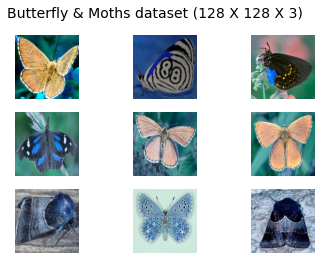

In [5]:
dataset = load_real_samples()
np.random.seed(42)
grid_plot(dataset[np.random.randint(0, 1000, 9)], name="Butterfly & Moths dataset (128 X 128 X 3)", n=3)

In [6]:
# Use modified build_conv_net and build_deconv_net functions in the tutorial
def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    model = tf.keras.Sequential()
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    model.add(Conv2D(input_shape=in_shape, **default_args, filters=filters))

    for _ in range(n_downsampling_layers):
        model.add(Conv2D(**default_args, filters=filters))

    model.add(Flatten())
    model.add(Dense(out_shape, activation=out_activation) )
    model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=5, filters=128, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that 
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers. 
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images. 
    """
    model = tf.keras.Sequential()
    model.add(Dense(4 * 4 * 128, input_dim=latent_dim)) 
    model.add(Reshape((4, 4, 128))) # This matches the output size of the downsampling architecture
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')
    
    for i in range(n_upsampling_layers):
        model.add(Conv2DTranspose(**default_args, filters=filters))

    # This last convolutional layer converts back to 3 channel RGB image
    model.add(Conv2D(filters=3, kernel_size=(3,3), activation=activation_out, padding='same'))
    model.summary()
    return model

## Convolutional Autoencoder

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 128)         147584    
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)              

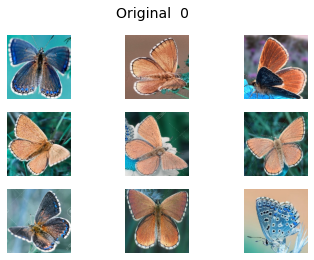

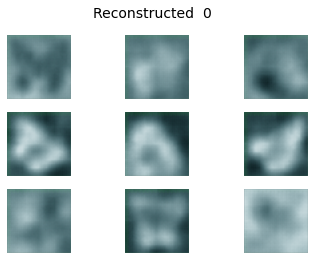


Epoch:  2


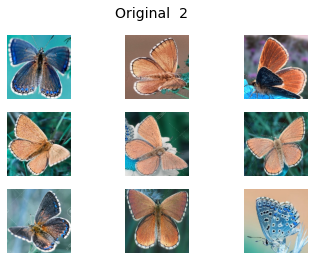

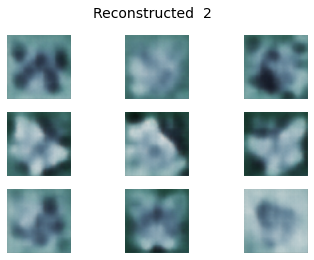


Epoch:  4


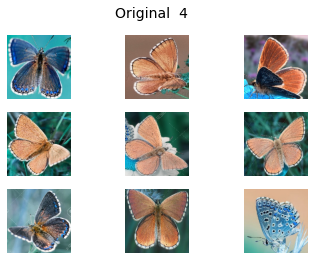

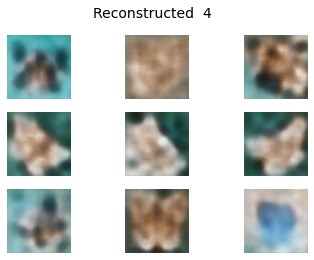


Epoch:  6


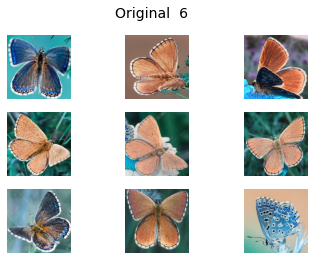

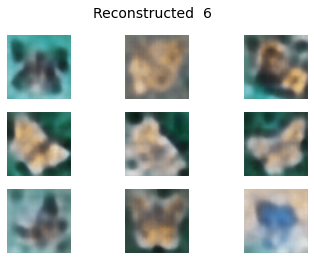


Epoch:  8


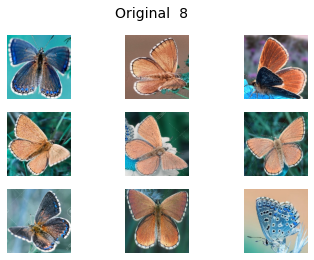

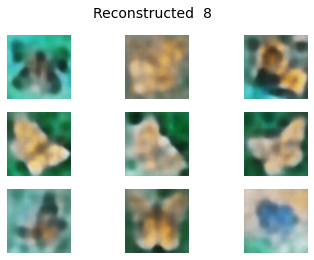

In [8]:
# CAE
# Use the build_convolutional_autoencoder function in the tutorial
def build_convolutional_autoencoder(data_shape, latent_dim, filters=128):
    encoder = build_conv_net(in_shape=data_shape, out_shape=latent_dim, filters=filters)
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
    return autoencoder

# Defining the model dimensions and building it
image_size = dataset.shape[1:]
latent_dim = 512
num_filters = 128
cae = build_convolutional_autoencoder(image_size, latent_dim, num_filters)

for epoch in range(0, 11):
    cae.fit(x=dataset, y=dataset, epochs=1, batch_size=64, verbose=0)
    if epoch % 2 == 0:
        print('\nEpoch: ', epoch)
        samples = dataset[:9]
        reconstructed = cae.predict(samples, verbose=0)
        grid_plot(samples, epoch, name='Original', n=3, save=False)
        grid_plot(reconstructed, epoch, name='Reconstructed', n=3, save=False)

## Variational Autoencoders (VAEs)

In [9]:
# Use the Sampling class and the build_vae function in the tutorial
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

    
def build_vae(data_shape, latent_dim, filters=128):

    # Building the encoder - starts with a simple downsampling convolutional network  
    encoder = build_conv_net(data_shape, latent_dim*2, filters=filters)
    
    # Adding special sampling layer that uses the reparametrization trick 
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])
    
    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))
    
    # Adding the special loss term
    kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
    vae.add_loss(kl_loss/tf.cast(tf.keras.backend.prod(data_shape), tf.float32))

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    return encoder, decoder, vae

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 128)       3584      
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 128)         147584    
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

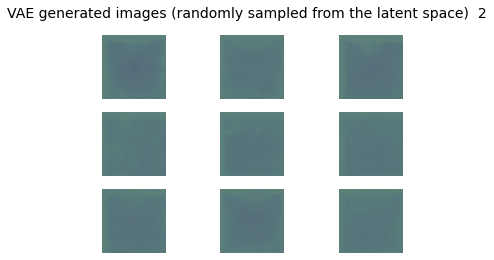

2022-11-17 04:26:08.122988: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.50GiB (rounded to 2681536512)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-11-17 04:26:08.123104: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-11-17 04:26:08.123133: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 79, Chunks in use: 79. 19.8KiB allocated for chunks. 19.8KiB in use in bin. 1.9KiB client-requested in use in bin.
2022-11-17 04:26:08.123149: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 90, Chunks in use: 90. 45.2KiB allocated for chunks. 45.2KiB in use in bin. 45.0KiB client-requested in use in bin.
2022-11-17 04:26:08.123163

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [10]:
# Training the VAE model

latent_dim = 32
encoder, decoder, vae = build_vae(dataset.shape[1:], latent_dim, filters=128)

# Generate random vectors that we will use to sample our latent space
for epoch in range(0, 21):
    vae.fit(x=dataset, y=dataset, epochs=1, batch_size=8, verbose=0)
    if epoch % 2 == 0:
        latent_vectors = np.random.randn(9, latent_dim)
        images = decoder(latent_vectors)
        grid_plot(images, epoch, name='VAE generated images (randomly sampled from the latent space)', n=3, save=False)

## Generative Adversarial Networks (GANs)

In [18]:
# Use build_gan, run_generator, get_batch, train_gan function in the tutorial
def build_gan(data_shape, latent_dim, filters=128, lr=0.0002, beta_1=0.5):
    optimizer = tf.optimizers.Adam(learning_rate=lr, beta_1=beta_1)

    # Usually thew GAN generator has tanh activation function in the output layer
    generator = build_deconv_net(latent_dim, activation_out='tanh', filters=filters)
    
    # Build and compile the discriminator
    discriminator = build_conv_net(in_shape=data_shape, out_shape=1, filters=filters) # Single output for binary classification
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return discriminator, generator, GAN


def run_generator(generator, n_samples=100):
    """
    Run the generator model and generate n samples of synthetic images using random latent vectors
    """
    latent_dim = generator.layers[0].input_shape[-1]
    generator_input = np.random.randn(n_samples, latent_dim)

    return generator.predict(generator_input)
    

def get_batch(generator, dataset, batch_size=64):
    """
    Gets a single batch of samples (X) and labels (y) for the training the discriminator.
    One half from the real dataset (labeled as 1s), the other created by the generator model (labeled as 0s).
    """
    batch_size //= 2 # Split evenly among fake and real samples

    fake_data = run_generator(generator, n_samples=batch_size)
    real_data = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

    X = np.concatenate([fake_data, real_data], axis=0)
    y = np.concatenate([np.zeros([batch_size, 1]), np.ones([batch_size, 1])], axis=0)

    return X, y


def train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs=20, batch_size=64):

    batches_per_epoch = int(dataset.shape[0] / batch_size / 2)
    for epoch in range(n_epochs):
        for batch in range(batches_per_epoch):
            
            # 1) Train discriminator both on real and synthesized images
            X, y = get_batch(generator, dataset, batch_size=batch_size)
            discriminator_loss = discriminator.train_on_batch(X, y)

            # 2) Train generator (note that now the label of synthetic images is reversed to 1)
            X_gan = np.random.randn(batch_size, latent_dim)
            y_gan = np.ones([batch_size, 1])
            generator_loss = gan.train_on_batch(X_gan, y_gan, verbose=0)

        noise = np.random.randn(16, latent_dim)
        images = generator.predict(noise)
        grid_plot(images, epoch, name='GAN generated images', n=3, save=False, scale=True)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1024)              263168    
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 64)          0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 8, 8, 128)        73856     
 Transpose)                                                      
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 16, 16, 128)      147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 32, 32, 128)      147584    
 Transpose)                                                      
                                                     

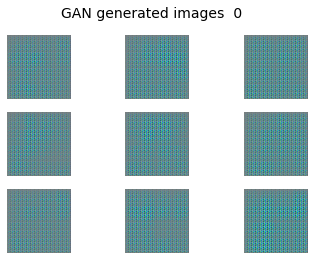

1/1 [==============================] - 0s 28ms/step


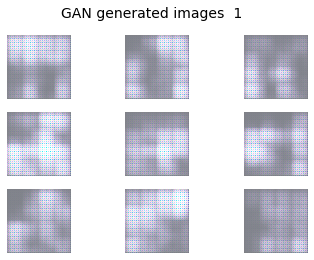

1/1 [==============================] - 0s 28ms/step


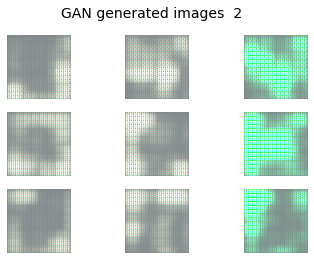

1/1 [==============================] - 0s 68ms/step


2022-11-17 03:54:16.834865: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 23ms/step


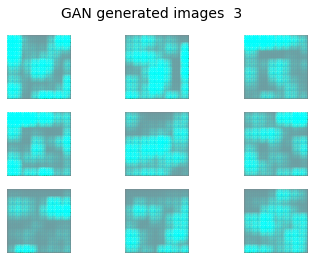

1/1 [==============================] - 0s 25ms/step


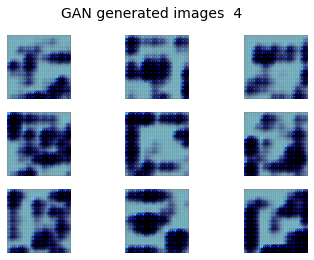

1/1 [==============================] - 0s 26ms/step


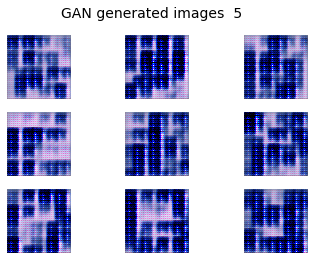

1/1 [==============================] - 0s 31ms/step


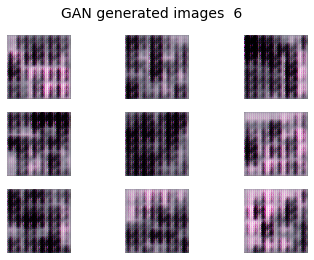

1/1 [==============================] - 0s 27ms/step


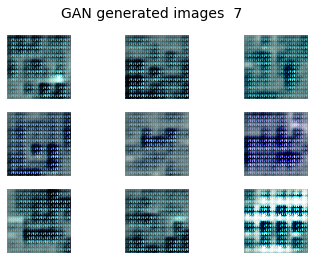

1/1 [==============================] - 0s 40ms/step


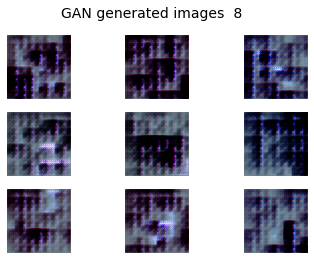

1/1 [==============================] - 0s 25ms/step


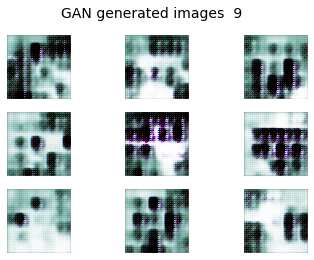

1/1 [==============================] - 0s 25ms/step


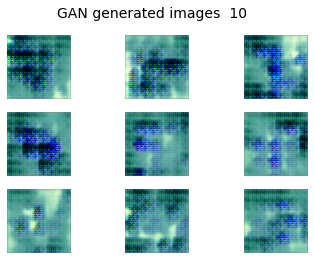

1/1 [==============================] - 0s 30ms/step


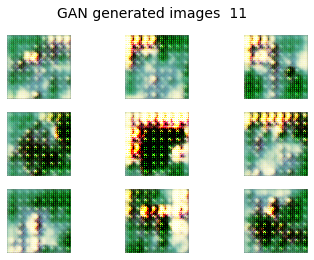

1/1 [==============================] - 0s 39ms/step


2022-11-17 03:57:46.030239: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 63ms/step


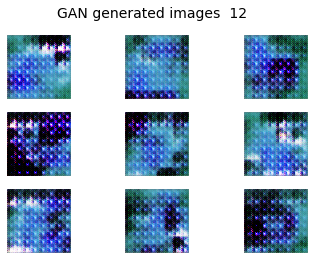

1/1 [==============================] - 0s 77ms/step


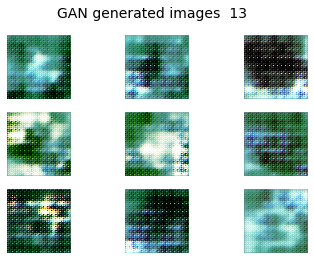

1/1 [==============================] - 0s 34ms/step


2022-11-17 03:58:43.530542: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 26ms/step


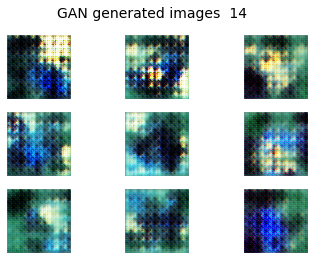

1/1 [==============================] - 0s 25ms/step


2022-11-17 03:58:59.940262: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 43ms/step


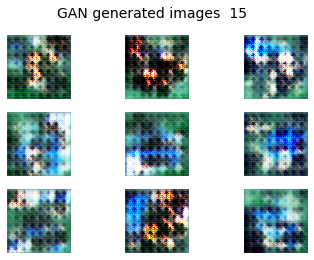

1/1 [==============================] - 0s 36ms/step


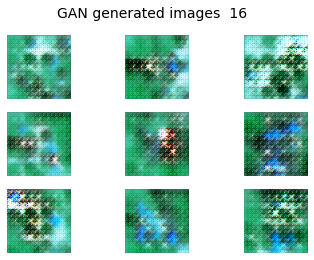

1/1 [==============================] - 0s 27ms/step


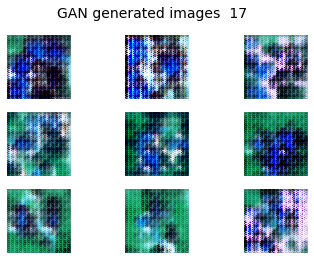

1/1 [==============================] - 0s 138ms/step


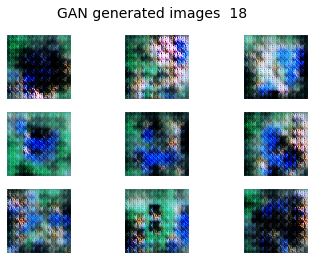

1/1 [==============================] - 0s 26ms/step


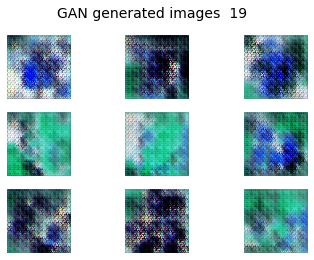

In [19]:
# Build and train the model (need around 10 epochs to start seeing some results)
latent_dim = 256
discriminator, generator, gan = build_gan(dataset.shape[1:], latent_dim, filters=128)
dataset_scaled = load_real_samples(scale=True)

train_gan(generator, discriminator, gan, dataset_scaled, latent_dim, n_epochs=20)